# Gene imputation with scRNA and smFISH in mouse cortex

Given two single-cell datasets profiled with different modalities scConfluence can map each in low-dimensional latent space shared by both modalities where distances between cell embeddings depends only on their biological similarity. These latent embeddings can then be leveraged to impute features across modalities. We show here an example of integration on a scRNA dataset with an smFISH dataset both from the mouse somatosensory cortex.

## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.spatial.distance import cdist
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import torch
torch.manual_seed(1792)

import scconfluence

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

You can download the unpaired multimodal dataset for this tutorial from https://figshare.com/s/72e156d0f131f8a3c810. 

In [2]:
mdata = mu.read_h5mu("RNA_smFISH_demo.h5mu.gz")
mdata

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 7535 × 20005
  obs:	'celltype', 'modality'
  2 modalities
    fish:	4530 x 33
      obs:	'x_coord', 'y_coord'
    rna:	3005 x 19972

## Perform basic quality control

We can use scanpy functions to filter out cells or features with low quality measurements.

In [3]:
sc.pp.filter_cells(mdata["rna"], min_genes=10)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["fish"], min_genes=5)
sc.pp.filter_genes(mdata["fish"], min_cells=20)
mdata.update()
mdata

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 7528 × 15254
  obs:	'celltype', 'modality'
  2 modalities
    fish:	4523 x 33
      obs:	'x_coord', 'y_coord', 'n_genes'
      var:	'n_cells'
    rna:	3005 x 15221
      obs:	'n_genes'
      var:	'n_cells'

## Hold out gene for imputation

To demonstrate scConfluence's ability to impute feature expression across modalities we will hide from the smFISH data the expression of a gene which was measured in the smFISH experiment, then impute it using scConfluence and compare its imputation to its held out ground truth value.

In [4]:
imputed_gene = "Sox10"

In [5]:
assert imputed_gene in mdata["rna"].var_names and imputed_gene in mdata["fish"].var_names

heldout_counts = mdata["fish"][:, imputed_gene].X.copy()
mdata.mod["fish"] = mdata["fish"][:, [g for g in mdata["fish"].var_names if g != imputed_gene]].copy()
mdata

MuData object with n_obs × n_vars = 7528 × 15254
  obs:	'celltype', 'modality'
  2 modalities
    fish:	4523 x 32
      obs:	'x_coord', 'y_coord', 'n_genes'
      var:	'n_cells'
    rna:	3005 x 15221
      obs:	'n_genes'
      var:	'n_cells'

## Preprocess common features and obtain cross-modality distance matrix

Diagonal integration, i.e. single cell multimodal unpaired integration, is a very challenging task as it aims at aligning cells in which different features were measured. To guide the alignment, we need to leverage prior biological knowledge to obtain a set of common features across modalities which will serve as a bridge for the integration. For scRNA-smFISH integration, those common features are the genes that have been measured in both experiments. 

In [6]:
# Keep only common genes
cm_genes = list(set(mdata["rna"].var_names) & set(mdata["fish"].var_names))
cm_features_rna = mdata["rna"][:, cm_genes].copy() 
cm_features_fish = mdata["fish"][:, cm_genes].copy() 

In [7]:
# Log normalize the scRNA counts
sc.pp.normalize_total(cm_features_rna, target_sum=1000.)
sc.pp.log1p(cm_features_rna)

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


To preprocess the smFISH counts, we use the same normalization technique as the authors of the dataset.

In [8]:
def normalize_fish(array, col_factor=None):
    array = array / array.sum(axis=1, keepdims=True)  # Corrected for total molecules per gene
    if col_factor is None:
        col_factor = array.mean(axis=0, keepdims=True)
    array = array / col_factor  # * array.shape[1]
    return array

In [9]:
# Normalize the fish counts
cm_features_fish.X = normalize_fish(cm_features_fish.X)

Once those common feature representations have been obtained, we can derive a distance matrix whose rows correspond to cells in the RNA modality and columns correspond to the cells in the FISH modality which will be used by scConfluence.

In [10]:
mdata.uns["cross_rna+fish"] = cdist(cm_features_rna.X, cm_features_fish.X, metric="correlation")
mdata.uns["cross_keys"] = ["cross_rna+fish"]

## Preprocess each modality

While the computation of the distance matrix only involved genes that were present both in the scRNA modality and the smFISH, our method leverages the original features of each modalities (i.e. all genes for the scRNA) to perform dimension reductions. Therefore, we need to preprocess each modality separately once again.

In [11]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()

# Log-normalize the scRNA counts
sc.pp.normalize_total(mdata["rna"], target_sum=10000.)
sc.pp.log1p(mdata["rna"])

# Since we use both raw and normalized gene counts it makes sense to select highly variable genes based on both criteria
raw_hvg = sc.pp.highly_variable_genes(mdata["rna"], layer="counts", n_top_genes=3000, subset=False, inplace=False, 
                                     flavor="seurat_v3")["highly_variable"].values
norm_hvg = sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=3000, subset=False, 
                                       inplace=False)["highly_variable"].values
mdata.mod["rna"] = mdata["rna"][:, np.logical_or(raw_hvg, norm_hvg)].copy()

# Perform PCA on the selected genes
sc.tl.pca(mdata["rna"], n_comps=100, zero_center=None)

In [12]:
mdata.mod["fish"].X = normalize_fish(mdata["fish"].X)

## Define autoencoders for each modality

We define one autoencoder per modality whose aim is to extract all the biological information present in the original features while accounting for batch effects (not present here since there's only one batch) and projecting the cells to a shared latent space of low dimension (hence the dimension of the latent space `n_latent` should be the same for all autoencoders). 
 
Multiple options can be set to adapt the autoencoders to the specificity of the modalities measured, see the [API's documention](https://scconfluence.readthedocs.io/en/latest/unimodal.html) for details about the arguments. We here use lower `n_hidden`and `n_layers_enc` than their default values since the smFISh measurements don't contain many features.

In [13]:
autoencoders = {"rna": scconfluence.unimodal.AutoEncoder(mdata["rna"], 
                                                         modality="rna", 
                                                         rep_in="X_pca", 
                                                         rep_out="counts", 
                                                         batch_key=None,
                                                         n_hidden=64, 
                                                         n_latent=16, 
                                                         type_loss="zinb"),
                "fish": scconfluence.unimodal.AutoEncoder(mdata["fish"], 
                                                          modality="fish", 
                                                          n_layers_enc=2,
                                                          rep_in=None, 
                                                          rep_out=None, 
                                                          batch_key=None,
                                                          n_hidden=25, 
                                                          n_latent=16, 
                                                          type_loss="l2")}

## Create and train the model

The scConfluence model leverages the distance matrix stored in `mdata` to align the latent embeddings learned by autoencoders from each modality. We used here the default parameters except for `iot_loss_weight` and `reach`. Indeed, here since the gene to gene connections which allow us to compute the cross-modality distance matrix are extremely reliable, we can increase the importance of the alignment term in the total loss. Increasing `reach` allow us to enforce an even tighter mixing of the modalities in the latent space, which is necessary for successful imputation. See the [API's documention](https://scconfluence.readthedocs.io/en/latest/model.html) or the [FAQ](https://scconfluence.readthedocs.io/en/latest/faq.html) for details on this. While the maximum over of epochs is set to 1000, we use earlystopping to interrupt the training when the loss has converged on validation samples which generally happens long before the upper limit of 1000 epochs. With a GPU, this training is expected to take less than 5 minutes.

In [14]:
%%time
%%capture
model = scconfluence.model.ScConfluence(mdata=mdata, unimodal_aes=autoencoders, 
                                        mass=0.5, reach=1., iot_loss_weight=0.05, sinkhorn_loss_weight=0.1)
model.fit(save_path="demo_rna_fish", use_cuda=True, max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | aes  | ModuleDict | 816 K 
------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.267     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


CPU times: user 3min 22s, sys: 2.59 s, total: 3min 25s
Wall time: 3min 29s


## Obtaining and visualizing latent embeddings of all cells

In [15]:
mdata.obsm["latent"] = model.get_latent(use_cuda=True).loc[mdata.obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████████████| 15/15 [00:00<00:00, 86.15it/s]


While conclusions should not be drawn from UMAP plots we use it here to visualize the results of the integration.

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


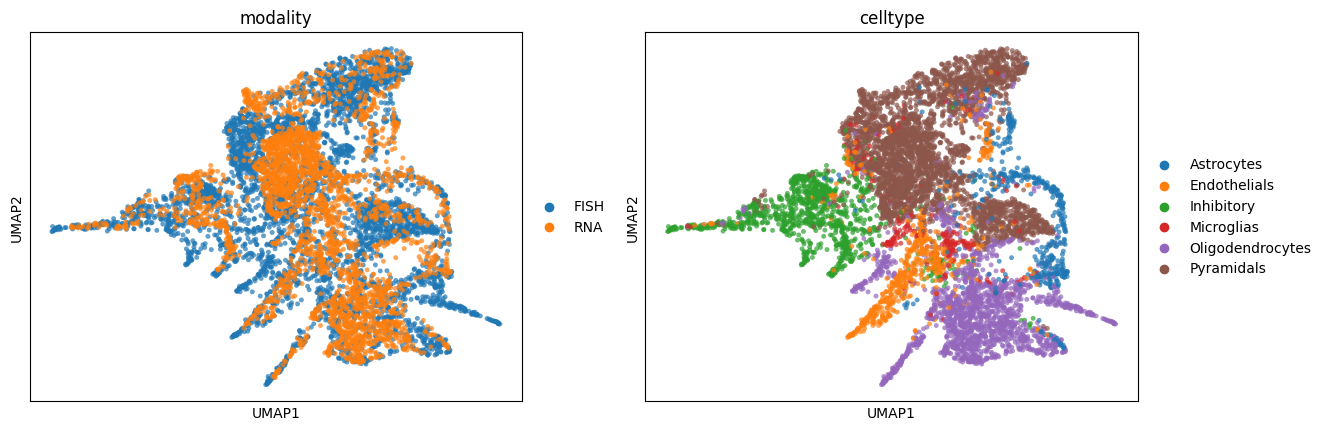

In [16]:
sc.pp.neighbors(mdata, use_rep="latent", key_added="scConfluence")
sc.tl.umap(mdata, neighbors_key="scConfluence")
sc.pl.umap(mdata, color=["modality", "celltype"], size=50, alpha=0.7)

## Imputing heldout measurements

Now that the model has been trained, we can use the RNA decoder to predict gene expression measurements from the smFISH latent embeddings.

In [17]:
imputed_gene_idx = list(mdata["rna"].var_names).index(imputed_gene)
mdata["fish"].obs[f"imputed_{imputed_gene}"] = model.get_imputation(use_cuda=True, 
                                                                    impute_from="fish", 
                                                                    impute_to="rna").iloc[:, imputed_gene_idx].loc[mdata["fish"].obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|███████████████████| 9/9 [00:00<00:00, 114.04it/s]


Since smFISH measurements come with 2D positions of the cells which were profiled, we can compare visually the spatial patterns of expression of the ground-truth and imputed expressions of the heldout gene.

In [18]:
def plot_spatial_expression(ax, x_coord, y_coord, values, title, s=20):
    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]
    x, y, z = order_by_strenght(x_coord, y_coord, values)
    c = np.arange(len(z)) / len(z)
    ax.scatter(x, y, c=c, s=s, edgecolors="none", rasterized=True)#, marker="s")  # , cmap="Reds")
    ax.axis('scaled')
    ax.axis("off")
    ax.set_title(title)

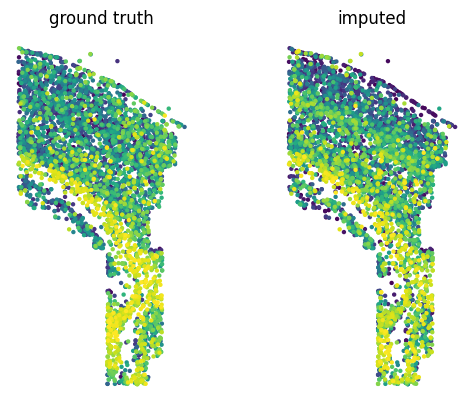

In [19]:
fig, (ax_gt, ax_imp) = plt.subplots(1, 2)
plot_spatial_expression(ax=ax_gt, x_coord=mdata["fish"].obs["x_coord"].values, 
                        y_coord=mdata["fish"].obs["y_coord"].values,
                        values=heldout_counts.reshape(-1), 
                        title="ground truth", 
                        s=10)
plot_spatial_expression(ax=ax_imp, x_coord=mdata["fish"].obs["x_coord"].values, 
                        y_coord=mdata["fish"].obs["y_coord"].values,
                        values=mdata["fish"].obs[f"imputed_{imputed_gene}"].values.reshape(-1), 
                        title="imputed", 
                        s=10)